In [17]:
#not needed- to be removed
def setUpImport():
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    from glob import glob
    from PIL import Image
    from tqdm import tqdm
    from keras.preprocessing import image
    %matplotlib inline
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from keras.utils.np_utils import to_categorical
    from sklearn.model_selection import train_test_split
    from keras.models import Sequential
    from keras.layers import Dense,Flatten
    import tensorflow as tf
    from tensorflow import keras

In [18]:
#create function to add image path location in metadata
def end_to_end_data_prep():
    base = '/cxldata/skin_disease_1/skinDisease_data'
    metadata = pd.read_csv(os.path.join(base,'HAM10000_metadata.csv'))
    #metadata.info()
    #if we combine data into one directory then no need to mention *
    image_path = {os.path.splitext(os.path.basename(x))[0]: x
                  for x in glob(os.path.join('/cxldata/skin_disease_1/HAM10000_images_draftv1/','*','*.jpg'))}
    metadata['path'] = metadata['image_id'].map(image_path.get)
    #upload data into dataset with resize 254,254
    #metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))
    
    return metadata

In [19]:
# this is for to plot images w.r.t. each category
def end_to_end_data_prep_plot(metadata):
    n_samples = 5  # number of samples for plotting
    # Plotting
    fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
    for n_axs, (type_name, type_rows) in zip(m_axs, metadata.sort_values(['dx']).groupby('dx')):
        n_axs[0].set_title(type_name)
        for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
            c_ax.imshow(c_row['image'])
            c_ax.axis('off')

In [20]:
#preparation for the augmentation
def data_prep_augmentation(path):
    img = load_img(path, target_size= (224,224))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    return x


In [21]:
#augmentation image generator
def data_prep_augmentation_generator(input_image_array,output_dir,output_prefix):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    i = 0
    for batch in datagen.flow(input_image_array, batch_size=1,save_to_dir=output_dir, save_prefix=output_prefix, save_format='jpg'):
        i += 1
        if i > 10:
            break

In [22]:
#data split
def dataSplit():
    
    # train test split for data preparation
    train,test = train_test_split(metadata,stratify=metadata['dx'],test_size=0.2)
    
    # save train data into csv to overcome processing again n again( 34120 records)
    train.to_csv('/cxldata/skin_disease_1/skinDisease_data/skinDisease_train_main.csv')
    
    # save test data into csv to overcome processing again n again ( 8530 records)
    test.to_csv('/cxldata/skin_disease_1/skinDisease_data/skinDisease_test_main.csv')
    return train,test

In [23]:
#get all train data
def getTrain_all():
    train_df = pd.read_csv('/cxldata/skin_disease_1/skinDisease_data/skinDisease_train_main.csv')
    return train_df

In [24]:
#get all test data 
def getTest_all():
    test_df = pd.read_csv('/cxldata/skin_disease_1/skinDisease_data/skinDisease_test_main.csv')
    return test_df

In [25]:
# created another df because we are not able to run fit model on 34120 records so created another df with 12000 recods
def getsplittrain(train_df):
    train_df1 = train_df[0:12000]
    return train_df1

In [26]:
#converting images into numpy array and adding 1 extra dimension(batch) for CNN
def convertTo4DArray(train_df1):
    train_image = []
    for i in tqdm(range(train_df1.shape[0])):
        img = image.load_img(train_df1['path'][i],target_size=[64,64,3])
        img = image.img_to_array(img)
        img = img/255
        train_image.append(img)
    X = np.array(train_image)
    return X

In [27]:
#applying encoder for y
def applyEncoderToLabel(train_df1):
    y = train_df1['dx'].values
    onehotencoder = OneHotEncoder(categories='auto',sparse=False)
    y = onehotencoder.fit_transform(y.reshape(-1,1))
    return y

In [28]:
#Model building
def buildModelAndTraining(X,y):
    base_model = keras.applications.vgg16.VGG16(weights="imagenet",
                                                      include_top=False,input_shape = (64,64,3))
    model_t1 = Sequential()
    model_t1.add(base_model)
    model_t1.add(Flatten())
    model_t1.add(Dense(64,activation="relu"))
    model_t1.add(Dense(7,activation="softmax"))
    #avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    #output = keras.layers.Dense(7, activation="softmax")(avg)
    #model = keras.models.Model(inputs=base_model.input, outputs=output)
    for layer in base_model.layers:
        layer.trainable = False
    
    #optimizer = keras.optimizers.SGD(lr=0.2)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,stratify=y,test_size=0.2)
    model_t1.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
    history = model_t1.fit(X_train,y_train,epochs=3,validation_data=(X_valid,y_valid)) #changed from 5
    
    model_t1.save('/cxldata/skin_disease_1/skinDisease_data/4_nadam.h5')

In [29]:
#prepare test dataset
def prepare_test_dataset(X,y):
    train_image = []
    for i in tqdm(range(test_df.shape[0])):
        img = image.load_img(test_df['path'][i],target_size=[64,64,3])
        img = image.img_to_array(img)
        img = img/255
        train_image.append(img)

    X_test = np.array(train_image)
    y_test = test_df['dx'].values
    onehotencoder = OneHotEncoder(categories='auto',sparse=False)
    y_test = onehotencoder.fit_transform(y_test.reshape(-1,1))
    return X_test,y_test

In [30]:
#evaluate the model
def evaluate_model(X_test,y_test):
    model = keras.models.load_model('/cxldata/skin_disease_1/skinDisease_data/4_nadam.h5')
    print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=128)
    print("test loss, test acc:", results)

In [31]:
#predict the test data- testing
def predict_test_data(X_test):
    model = keras.models.load_model('/cxldata/skin_disease_1/skinDisease_data/4_nadam.h5')
    y_pred=model.predict(X_test, batch_size=128)
    return y_pred

In [32]:
#predict
def predict(img_path1):
    model = keras.models.load_model('/cxldata/skin_disease_1/skinDisease_data/4_nadam.h5')
    # prediction for single image
    classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    #img_path1 = '/cxldata/skin_disease_1/HAM10000_images_draftv1/akiec2/akiec_0_9864.jpg'
    img1 = image.load_img(img_path1,color_mode='rgb', target_size=(64, 64))
    display(img1)
    x1 = image.img_to_array(img1)
    x1.shape
    # Adding the fouth dimension, for number of images
    x1 = np.expand_dims(x1, axis=0)

    x1 = preprocess_input(x1)
    features1 = model.predict(x1)
    features1
    #p = decode_predictions(features)
    MaxPosition=np.argmax(features1)  
    prediction_label=classes[MaxPosition]
    print('*************prediction_label**********',prediction_label) 
    return prediction_label

In [33]:
#confusion matrix
def confusionMatrixAndAccuracySummary(y_pred):
    rounded_labels=np.argmax(y_test, axis=1)
    y_pred_1=np.argmax(y_pred, axis=1)

    print('rounded_labels===>' '\n',classification_report(rounded_labels, y_pred_1))
    cm = confusion_matrix(rounded_labels, y_pred_1)
    print('confusion matix===>' '\n',cm)
    
    print('-----------------classification_report----------------' '\n',classification_report(rounded_labels, y_pred_1))

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image
from tqdm import tqdm
from keras.preprocessing import image
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions


#create function to add image path location in metadata
metadata=end_to_end_data_prep()
print("--------------------end_to_end_data_preparation completed --------------------")

# his is for to plot images w.r.t. each category
#########end_to_end_data_prep_plot(metadata)

#data split
train,test = dataSplit()
print("--------------------dataSplit completed --------------------")


#get all train data
train_df = getTrain_all()

#get all test data 
test_df = getTest_all()

#get top 12000 records
train_df1 = getsplittrain(train_df)

#converting images into numpy array and adding 1 extra dimension(batch) for CNN
X = convertTo4DArray(train_df1)
print("--------------------convertTo4DArray completed --------------------")

#applying encoder for y
y = applyEncoderToLabel(train_df1)
print("--------------------label encoding completed --------------------")

print("--------------------model construcrtion and training started --------------------")
#build the model 
buildModelAndTraining(X,y)
print("--------------------model construcrtion and training finished --------------------")

#prepare test dataset
X_test,y_test = prepare_test_dataset(X,y)

print("--------------------evaluation started --------------------")
#evaluate the model
evaluate_model(X_test,y_test)
print("--------------------evaluation completed --------------------")

#predict the test data- testing
y_pred = predict_test_data(X_test)

print("-------------------- confusionMatrixAndAccuracySummary started --------------------")
confusionMatrixAndAccuracySummary(y_pred)
print("-------------------- confusionMatrixAndAccuracySummary completed --------------------")


--------------------end_to_end_data_preparation completed --------------------


  0%|          | 0/12000 [00:00<?, ?it/s]

--------------------dataSplit completed --------------------


100%|██████████| 12000/12000 [04:55<00:00, 40.60it/s]
W1120 09:43:15.711226 140636660291392 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


--------------------convertTo4DArray completed --------------------
--------------------label encoding completed --------------------
--------------------model construcrtion and training started --------------------
Train on 9600 samples, validate on 2400 samples
Epoch 1/3
9600/9600 [==============================] - 198s 21ms/sample - loss: 0.8586 - acc: 0.7349 - val_loss: 0.6018 - val_acc: 0.8188
Epoch 2/3
9600/9600 [==============================] - 196s 20ms/sample - loss: 0.4514 - acc: 0.8761 - val_loss: 0.4115 - val_acc: 0.8850
Epoch 3/3
9600/9600 [==============================] - 197s 21ms/sample - loss: 0.3557 - acc: 0.9024 - val_loss: 0.3667 - val_acc: 0.8946


  0%|          | 5/8530 [00:00<03:26, 41.30it/s]

--------------------model construcrtion and training finished --------------------


100%|██████████| 8530/8530 [03:11<00:00, 44.62it/s]
W1120 09:56:22.740607 140636660291392 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1120 09:56:22.741871 140636660291392 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


--------------------evaluation started --------------------
Evaluate on test data
8530/8530 [==============================] - 134s 16ms/sample - loss: 0.3641 - acc: 0.8951
test loss, test acc: [0.36405526781836817, 0.8950762]
--------------------evaluation completed --------------------
-------------------- confusionMatrixAndAccuracySummary started --------------------
rounded_labels===>
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1121
           1       0.96      0.85      0.90      1031
           2       0.90      0.84      0.87      1253
           3       0.93      0.93      0.93      1256
           4       0.93      0.85      0.89      1302
           5       0.80      0.87      0.83      1341
           6       0.92      0.98      0.95      1226

    accuracy                           0.90      8530
   macro avg       0.90      0.90      0.90      8530
weighted avg       0.90      0.90      0.90      8530

confusion 

--------------------prediction started --------------------


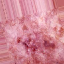

*************prediction_label********** akiec


'akiec'

In [37]:
#predict
print("--------------------prediction started --------------------")
img_path1 = '/cxldata/skin_disease_1/HAM10000_images_draftv1/akiec2/akiec_0_9864.jpg'
predict(img_path1)